# 0. Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -r drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects/requirements.txt -q

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import matplotlib.pyplot as plt
import time
import copy


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score



import shutil
import os
import cv2
import albumentations as A

from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import models, transforms

from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
if torch.cuda.is_available():
    device = torch.device(0)



In [ ]:
base_path = "drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects/"

In [ ]:
! ls "drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects"

'6.2 Church Prez.gslides'      preprocessing.ipynb
 archive_new_6.26.zip	       requirements.txt
 archive_new.zip	       Scraping.ipynb
 archive_orig.zip	      'sources   notes.gsheet'
 deep_architects_mitch.ipynb   styles_filepath.csv
 model_checkpoint_mjv1.pt      Univ_Washington.csv


In [ ]:
df = pd.read_csv(base_path+'styles_filepath.csv')
print(df.shape)
df.head()

(10113, 5)


,class_index,class_label,filepath,height,width
0,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,681,968
1,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,534,800
2,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,668,1000
3,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,663,1000
4,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,600,800


In [ ]:
df.class_label.value_counts()

Queen Anne architecture             720
Art Nouveau architecture            615
Art Deco architecture               566
Greek Revival architecture          523
Colonial architecture               480
Baroque architecture                456
Tudor Revival architecture          455
Beaux-Arts architecture             424
International style                 417
Ancient Egyptian architecture       406
Achaemenid architecture             392
Novelty architecture                382
Georgian architecture               381
American craftsman style            364
American Foursquare architecture    362
Russian Revival architecture        352
Palladian architecture              343
Deconstructivism                    335
Gothic architecture                 331
Postmodern architecture             322
Bauhaus architecture                315
Byzantine architecture              313
Romanesque architecture             301
Edwardian architecture              280
Chicago school architecture         278


In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
df_train.head(1)

,class_index,class_label,filepath,height,width
7329,17,Russian Revival architecture,archive/architectural-styles-dataset/Russian R...,600,450


In [ ]:
! ls "drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects/"

'6.2 Church Prez.gslides'       preprocessing.ipynb
 archive_new_6.26.zip	        requirements.txt
 archive_new_6.27_256x256.zip   Scraping.ipynb
 archive_new.zip	       'sources   notes.gsheet'
 archive_orig.zip	        styles_filepath.csv
 deep_architects_mitch.ipynb    Univ_Washington.csv
 model_checkpoint_mjv1.pt


In [ ]:
# !rm -r archive

In [ ]:
! cp "drive/MyDrive/Colab_Notebooks/deep_learning/final_project/deep_architects/archive_new_6.27_256x256.zip" archive_new.zip

In [ ]:
# extract and delete
!unzip -q archive_new.zip

!rm archive_new.zip -r

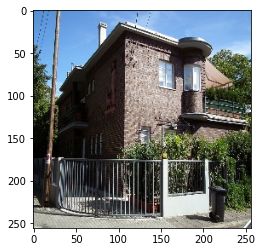

In [ ]:
# pull up an image
row = df.iloc[10]
image_path = row['filepath']

img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

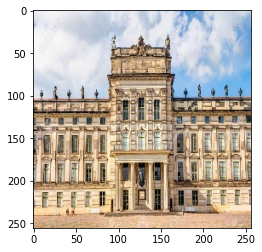

In [ ]:
# pull up an image
row = df_valid.iloc[1]
image_path = row['filepath']

img = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [ ]:
df.head(2)

,class_index,class_label,filepath,height,width
0,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,681,968
1,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,534,800


In [ ]:
demo_df = df.groupby('class_index').last().reset_index()
demo_df.head(2)

,class_index,class_label,filepath,height,width
0,0,Bauhaus architecture,archive/architectural-styles-dataset/Bauhaus a...,1000,750
1,1,Queen Anne architecture,archive/architectural-styles-dataset/Queen Ann...,600,650


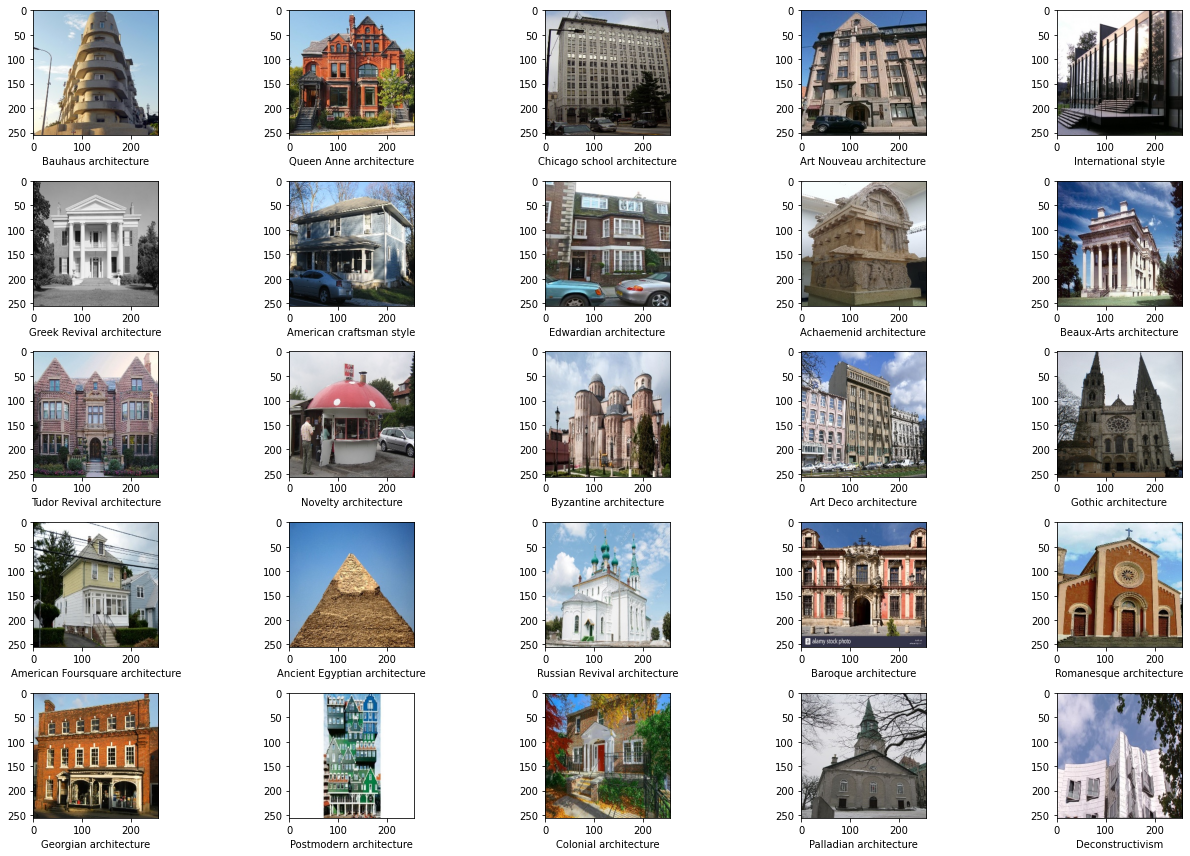

In [ ]:
xdim=5
ydim=5

figure, axis = plt.subplots(ydim, xdim, figsize =(18, 12))
for i in range(ydim):
    for j in range(xdim):
        row = demo_df.iloc[xdim*i+j, 1:3]
        img = cv2.imread(row[1])
        axis[i][j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
        axis[i][j].set_xlabel(row[0])

plt.tight_layout()
plt.show()

## Dataset

In [ ]:
class ArchStyleAugment(Dataset):
    def __init__(self, df, augment=False):
        self.df = df

        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
 
                # pixel-level transformation
                # A.RandomBrightnessContrast(p=1),
                A.GaussNoise(p=1),
                
                # we will normalize according to ImageNet since we will be using a pre-trained VGG
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                A.CenterCrop(width=224, height=224),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
    

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path = row['filepath']
        
        # read the img
        img = cv2.imread(path)

        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Transform
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(row['class_index'])
        
        return img, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor(17)


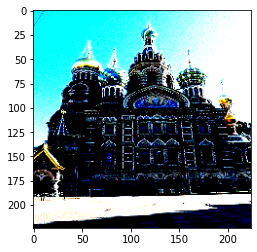

In [ ]:
ds_train = ArchStyleAugment(df_train, augment=True)

img, label = next(iter(ds_train))
print(img.shape)
# restructure for plt
img = np.transpose(np.array(img), (1,2,0))

# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(img)
print(label)

In [ ]:
def one_pass(model, dataloader, optimizer, scheduler, lossFun, backprop):
    
    if backprop == True:
        model.train()
    else:
        model.eval()

    # softmax = nn.Softmax(dim=1)


    y_true = []
    y_pred = []    
    total_loss = 0
    obs_count = 0

    for x, y in tqdm(dataloader):
        y_hat = model(x)
        loss = lossFun(y_hat, y.type(torch.LongTensor))

        y_hat = torch.argmax(y_hat, dim=1)

        y_true.append(y)
        y_pred.append(y_hat)

        total_loss += loss.item()
        obs_count += len(y)

        if backprop == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        

    avg_loss = total_loss / obs_count

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    return (avg_loss, accuracy, balanced_accuracy)


def train_loop(epochs, train_dl_var, valid_dl_var, model_var, optimizer_var, loss_var, scheduler_var, file_name, gdrive_save):
    best_loss = 100
    metrics = []
    for epoch in tqdm(range(1, epochs+1)):
        start_time = time.time()
        train_loss = one_pass(model, train_dl_var, optimizer_var, scheduler_var, loss_var, backprop=True)
        valid_loss = one_pass(model, valid_dl_var, optimizer_var, scheduler_var, loss_var, backprop=False)
        end_time = time.time()
        elapsed = (end_time - start_time) / 60

        if valid_loss[0] < best_loss:
            save_model_weights(file_name, gdrive_save)
            best_loss = valid_loss[0]

        print('epoch:', str(epoch).rjust(2, '0'), \
              ' train_loss:'   , str(round(train_loss[0], 5)).ljust(7, '0'), \
              ' train_acc:'    , str(round(train_loss[1], 5)).ljust(7, '0'), \
              ' train_balacc:' , str(round(train_loss[2], 5)).ljust(7, '0'), \

              ' valid_loss:'   , str(round(valid_loss[0], 5)).ljust(7, '0'), \
              ' valid_acc:'    , str(round(valid_loss[1], 5)).ljust(7, '0'), \
              ' valid_balacc:' , str(round(valid_loss[2], 5)).ljust(7, '0'), \

              ' mins:', str(round(elapsed, 3)).ljust(5, '0'))

    return None

def save_model_weights(output_model_file, gdrive_save=False):
    # assumes model=model, optimizer=optimizer
    checkpoint = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict' : optimizer.state_dict()}

    if gdrive_save:
        output_model_file = base_path + output_model_file
        torch.save(checkpoint, output_model_file)
    else:
        torch.save(checkpoint, output_model_file)

In [ ]:
resnet = models.resnet18(pretrained=True)

# turn off gradients for all the parameters
for param in resnet.parameters():
    param.requires_grad = False

# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 25)
print(resnet.fc)

# re-initializing the layer reset to default settings
for param in resnet.fc.parameters():
    print(param.requires_grad)


# pass the appropriate parameters to the optimizer
params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
# print(params_to_update)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=25, bias=True)
True
True


https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y = df_train.class_index.values
class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float)
 
print(class_weights)

tensor([1.3154, 0.5340, 1.5264, 0.6551, 0.9602, 0.7760, 1.1275, 1.4070, 1.0506,
        0.9776, 0.9272, 1.0405, 1.2258, 0.7191, 1.2030, 1.0896, 1.0896, 1.1236,
        0.8722, 1.2791, 1.1275, 1.3208, 0.8151, 1.1682, 1.2120])


In [ ]:
top5_favs = ['Gothic architecture', 'Byzantine architecture', 'Greek Revival architecture', \
             'Russian Revival architecture', 'Art Deco architecture']

In [ ]:
re_index = {v: k for k, v in dict(enumerate(top5_favs)).items()}
re_index

{'Art Deco architecture': 4,
 'Byzantine architecture': 1,
 'Gothic architecture': 0,
 'Greek Revival architecture': 2,
 'Russian Revival architecture': 3}

In [ ]:
df_filt = df[df['class_label'].isin(top5_favs)]
df_filt.head(2)

,class_index,class_label,filepath,height,width
2345,5,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,480,640
2346,5,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,600,800


In [ ]:
df_filt['class_index'] = df_filt['class_label'].map(re_index)
df_filt.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,class_index,class_label,filepath,height,width
2345,2,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,480,640
2346,2,Greek Revival architecture,archive/architectural-styles-dataset/Greek Rev...,600,800


In [ ]:
df_train, df_valid = train_test_split(df_filt, test_size=0.2, random_state=0)

# Resnet - partially frozen

In [ ]:
resnet = models.resnet18(pretrained=True)

# turn off gradients for all the parameters
for param in resnet.parameters():
    param.requires_grad = False

# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 5)
print(resnet.fc)

# re-initializing the layer reset to default settings
for param in resnet.fc.parameters():
    print(param.requires_grad)


# pass the appropriate parameters to the optimizer
params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
# print(params_to_update)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=5, bias=True)
True
True


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y = df_train.class_index.values
class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float)
 
print(class_weights)

tensor([1.2831, 1.2880, 0.8039, 1.1788, 0.7397])


In [ ]:
batch_size = 32

train_dl = DataLoader(ArchStyleAugment(df_train, augment=True), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ArchStyleAugment(df_valid, augment=False), batch_size=batch_size, shuffle=False)

model = resnet
loss_func = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(params_to_update, lr=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85)


train_loop(epochs=10, train_dl_var=train_dl, valid_dl_var=valid_dl, model_var=model, \
           loss_var=loss_func, optimizer_var=optimizer, scheduler_var = scheduler, \
           file_name='model_checkpoint_mjv_resnet_5classes.pt', gdrive_save=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 01  train_loss: 0.02525  train_acc: 0.71403  train_balacc: 0.70410  valid_loss: 0.01610  valid_acc: 0.82734  valid_balacc: 0.82111  mins: 2.667


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 02  train_loss: 0.01851  train_acc: 0.79916  train_balacc: 0.79069  valid_loss: 0.01665  valid_acc: 0.79856  valid_balacc: 0.78596  mins: 2.685


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 03  train_loss: 0.01793  train_acc: 0.79017  train_balacc: 0.78182  valid_loss: 0.01617  valid_acc: 0.82254  valid_balacc: 0.80896  mins: 2.686


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 04  train_loss: 0.01736  train_acc: 0.79736  train_balacc: 0.79011  valid_loss: 0.01557  valid_acc: 0.82734  valid_balacc: 0.81175  mins: 2.653


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 05  train_loss: 0.01659  train_acc: 0.82134  train_balacc: 0.81742  valid_loss: 0.01701  valid_acc: 0.81055  valid_balacc: 0.80099  mins: 2.679


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 06  train_loss: 0.01653  train_acc: 0.81954  train_balacc: 0.81264  valid_loss: 0.01636  valid_acc: 0.82014  valid_balacc: 0.80638  mins: 2.688


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 07  train_loss: 0.01485  train_acc: 0.83153  train_balacc: 0.82830  valid_loss: 0.01606  valid_acc: 0.83453  valid_balacc: 0.81886  mins: 2.665


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 08  train_loss: 0.01553  train_acc: 0.83993  train_balacc: 0.83382  valid_loss: 0.01569  valid_acc: 0.82734  valid_balacc: 0.81249  mins: 2.682


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 09  train_loss: 0.01553  train_acc: 0.82914  train_balacc: 0.81721  valid_loss: 0.01654  valid_acc: 0.82494  valid_balacc: 0.80616  mins: 2.636


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 10  train_loss: 0.01481  train_acc: 0.83933  train_balacc: 0.83291  valid_loss: 0.01651  valid_acc: 0.82494  valid_balacc: 0.80983  mins: 2.653


# Resnet - finetune

In [ ]:
resnet = models.resnet18(pretrained=True)

# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 5)
print(resnet.fc)


# pass the appropriate parameters to the optimizer
params_to_update = []
for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print(len(params_to_update))

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=5, bias=True)
62


In [ ]:
batch_size = 32

train_dl = DataLoader(ArchStyleAugment(df_train, augment=True), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ArchStyleAugment(df_valid, augment=False), batch_size=batch_size, shuffle=False)

model = resnet
loss_func = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(params_to_update, lr=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85)


train_loop(epochs=10, train_dl_var=train_dl, valid_dl_var=valid_dl, model_var=model, \
           loss_var=loss_func, optimizer_var=optimizer, scheduler_var = scheduler, \
           file_name='model_checkpoint_mjv_resnet_finetune_5classes.pt', gdrive_save=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 01  train_loss: 0.03673  train_acc: 0.71523  train_balacc: 0.70366  valid_loss: 0.02731  valid_acc: 0.77458  valid_balacc: 0.75326  mins: 6.117


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 02  train_loss: 0.01396  train_acc: 0.84712  train_balacc: 0.84130  valid_loss: 0.01792  valid_acc: 0.83933  valid_balacc: 0.82492  mins: 6.006


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 03  train_loss: 0.01090  train_acc: 0.87950  train_balacc: 0.87347  valid_loss: 0.01515  valid_acc: 0.86811  valid_balacc: 0.85846  mins: 6.006


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 04  train_loss: 0.00939  train_acc: 0.90767  train_balacc: 0.90011  valid_loss: 0.01335  valid_acc: 0.87530  valid_balacc: 0.86236  mins: 6.024


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 05  train_loss: 0.00941  train_acc: 0.91487  train_balacc: 0.90834  valid_loss: 0.01740  valid_acc: 0.86091  valid_balacc: 0.84709  mins: 5.997


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 06  train_loss: 0.00987  train_acc: 0.89448  train_balacc: 0.88999  valid_loss: 0.01352  valid_acc: 0.86091  valid_balacc: 0.84242  mins: 6.017


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 07  train_loss: 0.00758  train_acc: 0.92026  train_balacc: 0.91505  valid_loss: 0.01331  valid_acc: 0.87050  valid_balacc: 0.85437  mins: 5.934


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 08  train_loss: 0.00768  train_acc: 0.91906  train_balacc: 0.91576  valid_loss: 0.01416  valid_acc: 0.86331  valid_balacc: 0.84603  mins: 5.927


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 09  train_loss: 0.00560  train_acc: 0.94125  train_balacc: 0.93698  valid_loss: 0.01351  valid_acc: 0.86571  valid_balacc: 0.85425  mins: 5.904


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 10  train_loss: 0.00513  train_acc: 0.94844  train_balacc: 0.94646  valid_loss: 0.01421  valid_acc: 0.87530  valid_balacc: 0.85599  mins: 5.910


# Resnet - from scratch

In [ ]:
resnet = models.resnet18(pretrained=False)

# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 5)
print(resnet.fc)


# pass the appropriate parameters to the optimizer
params_to_update = []
for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print(len(params_to_update))

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=5, bias=True)
62


In [ ]:
batch_size = 32

train_dl = DataLoader(ArchStyleAugment(df_train, augment=True), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ArchStyleAugment(df_valid, augment=False), batch_size=batch_size, shuffle=False)

model = resnet
loss_func = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(params_to_update, lr=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85)


train_loop(epochs=10, train_dl_var=train_dl, valid_dl_var=valid_dl, model_var=model, \
           loss_var=loss_func, optimizer_var=optimizer, scheduler_var = scheduler, \
           file_name='model_checkpoint_mjv_resnet_scratch_5classes.pt', gdrive_save=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 01  train_loss: 0.05289  train_acc: 0.33453  train_balacc: 0.32645  valid_loss: 0.04714  valid_acc: 0.45084  valid_balacc: 0.39161  mins: 6.536


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 02  train_loss: 0.04258  train_acc: 0.43945  train_balacc: 0.43992  valid_loss: 0.04191  valid_acc: 0.48921  valid_balacc: 0.44370  mins: 6.895


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch: 03  train_loss: 0.03901  train_acc: 0.48501  train_balacc: 0.48928  valid_loss: 0.03851  valid_acc: 0.51799  valid_balacc: 0.50519  mins: 6.909


  0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# VGG16 - partially frozen

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# turn off gradients for all the parameters
for param in vgg16.parameters():
    param.requires_grad = False

print(vgg16.classifier[6])
vgg16.classifier[6] = nn.Linear(4096, 5)
print(vgg16.classifier[6])


# re-initializing the layer reset to default settings
for param in vgg16.classifier[6].parameters():
    print(param.requires_grad)



# pass the appropriate parameters to the optimizer
params_to_update = []

for param in vgg16.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print(params_to_update)


Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=5, bias=True)
True
True
[Parameter containing:
tensor([[-0.0094, -0.0083, -0.0144,  ..., -0.0026,  0.0126, -0.0044],
        [-0.0089, -0.0007, -0.0048,  ..., -0.0098,  0.0069, -0.0015],
        [-0.0058,  0.0069, -0.0123,  ...,  0.0026, -0.0151,  0.0142],
        [-0.0047, -0.0136,  0.0092,  ...,  0.0124, -0.0051,  0.0106],
        [-0.0154,  0.0045,  0.0097,  ..., -0.0110,  0.0030, -0.0115]],
       requires_grad=True), Parameter containing:
tensor([ 0.0133,  0.0081,  0.0120,  0.0108, -0.0062], requires_grad=True)]


In [ ]:
batch_size = 16

train_dl = DataLoader(ArchStyleAugment(df_train, augment=True), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ArchStyleAugment(df_valid, augment=False), batch_size=batch_size, shuffle=False)

model = vgg16
loss_func = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(params_to_update, lr=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=10,mode="exp_range",gamma=0.85)

train_loop(epochs=10, train_dl_var=train_dl, valid_dl_var=valid_dl, model_var=model, \
           loss_var=loss_func, optimizer_var=optimizer, scheduler_var = scheduler, \
           file_name='model_checkpoint_mjv_vgg_5classes.pt', gdrive_save=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch: 01  train_loss: 0.24600  train_acc: 0.65288  train_balacc: 0.63790  valid_loss: 0.12837  valid_acc: 0.78417  valid_balacc: 0.76869  mins: 15.35


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch: 02  train_loss: 0.18313  train_acc: 0.69844  train_balacc: 0.68423  valid_loss: 0.10856  valid_acc: 0.81535  valid_balacc: 0.80691  mins: 15.318


  0%|          | 0/105 [00:00<?, ?it/s]

KeyboardInterrupt: ignored